## **Wykrywanie naczyń dna siatkówki oka**

### *Biblioteki*

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

### *Funkcje*

In [2]:
def show_image(image, title=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title) if title else None
    plt.axis('off')
    plt.show()

### 0. Wczytanie obrazu

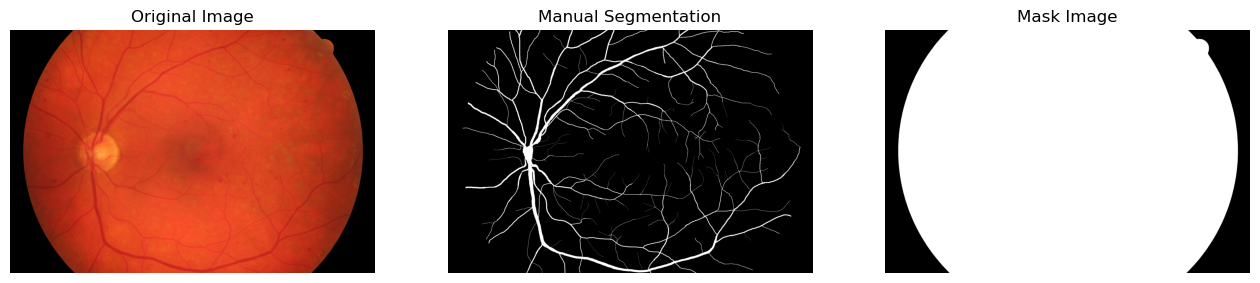

Szerokość obrazu: 3504
Wysokość obrazu: 2336
Szerokość obrazu maski: 3504
Wysokość obrazu maski: 2336


In [41]:
image_path = 'HRF-database/images/01_dr.JPG'
originalImage = cv2.imread(image_path)

segmentedImage_path = 'HRF-database/manual1/01_dr.tif'
segmentedImage = cv2.imread(segmentedImage_path)

mask_path = 'HRF-database/mask/01_dr_mask.tif'
maskImage = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(16, 12))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(segmentedImage, cv2.COLOR_BGR2RGB))
plt.title('Manual Segmentation')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(maskImage, cmap='gray')
plt.title('Mask Image')
plt.axis('off')

plt.show()

print("Szerokość obrazu:", originalImage.shape[1])
print("Wysokość obrazu:", originalImage.shape[0])

print("Szerokość obrazu maski:", maskImage.shape[1])
print("Wysokość obrazu maski:", maskImage.shape[0])


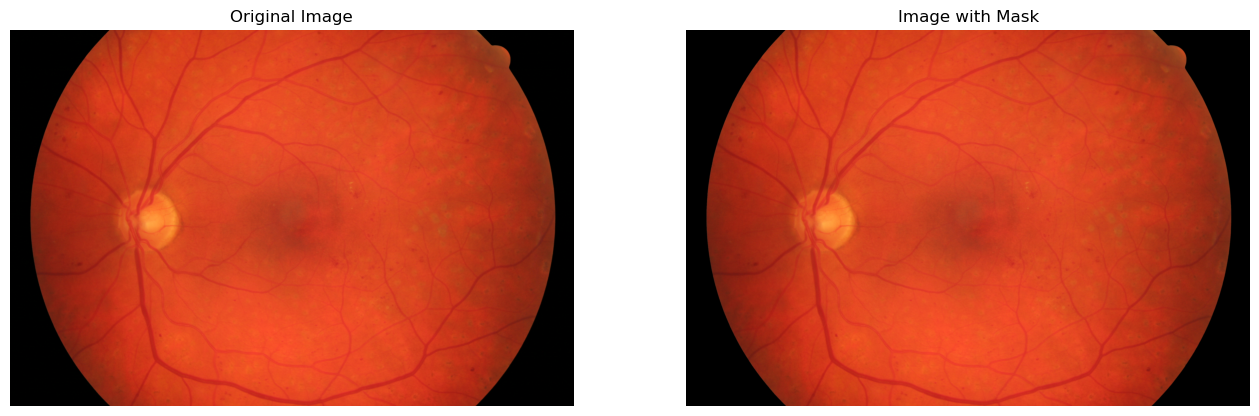

In [59]:
# to fix (usuwanie konturu oka widocznego po segmentacji)
# Perform bitwise AND between the original image and inverted mask to remove pixels outside the eye region
image_with_mask = cv2.bitwise_and(originalImage, originalImage, mask=maskImage)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_with_mask, cv2.COLOR_BGR2RGB))
plt.title('Image with Mask')
plt.axis('off')

plt.show()

### 1. Przetowrzenie obrazu

- usunięcie tła 

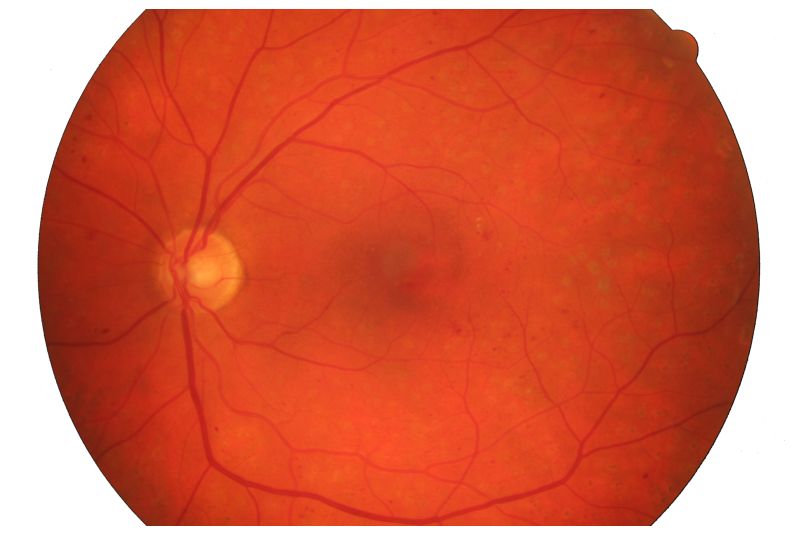

In [43]:
image = image_with_mask.copy()
threshold = 6 # Próg dla każdego kanału kolorów

image[np.where((originalImage < threshold).all(axis=2))] = [255, 255, 255] # transformacja

show_image(image)

- filtr Gamma

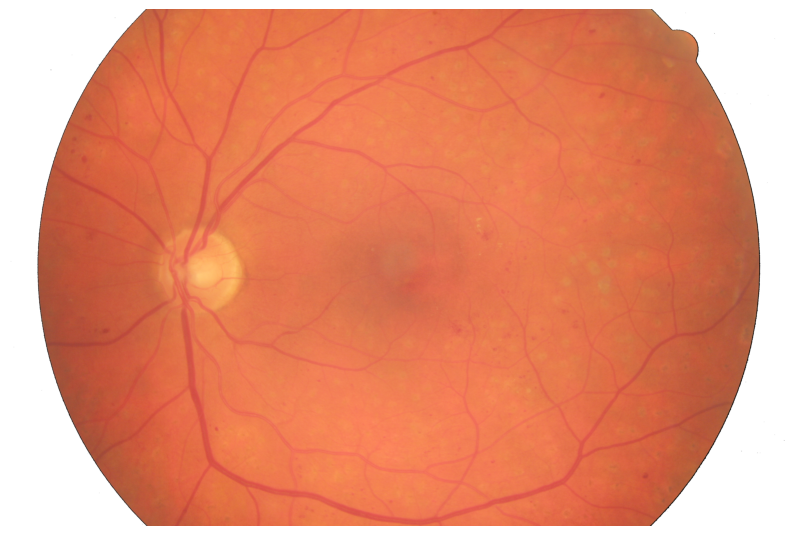

In [44]:
gamma = 1.75
gamma_corrected_image = np.uint8(((image / 255.0) ** (1 / gamma)) * 255)
show_image(gamma_corrected_image)

- Konwersja do skali szarości

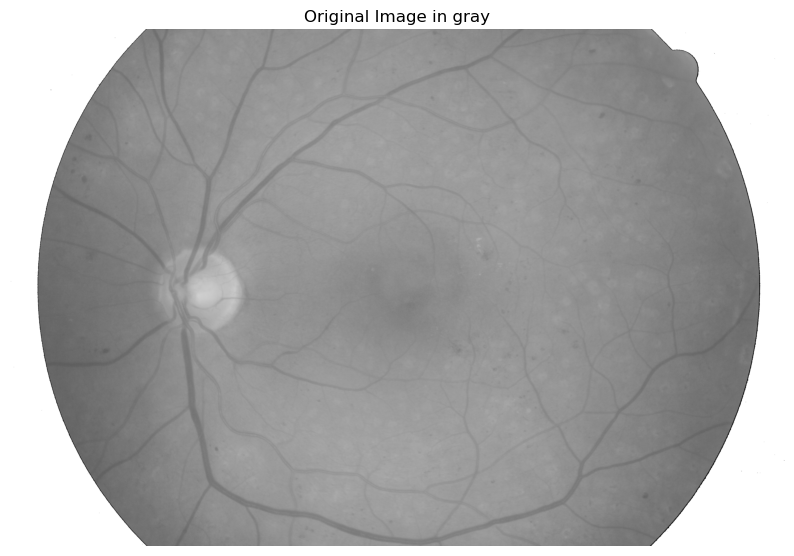

In [45]:
gray = cv2.cvtColor(gamma_corrected_image, cv2.COLOR_BGR2GRAY)
show_image(gray, title='Original Image in gray')

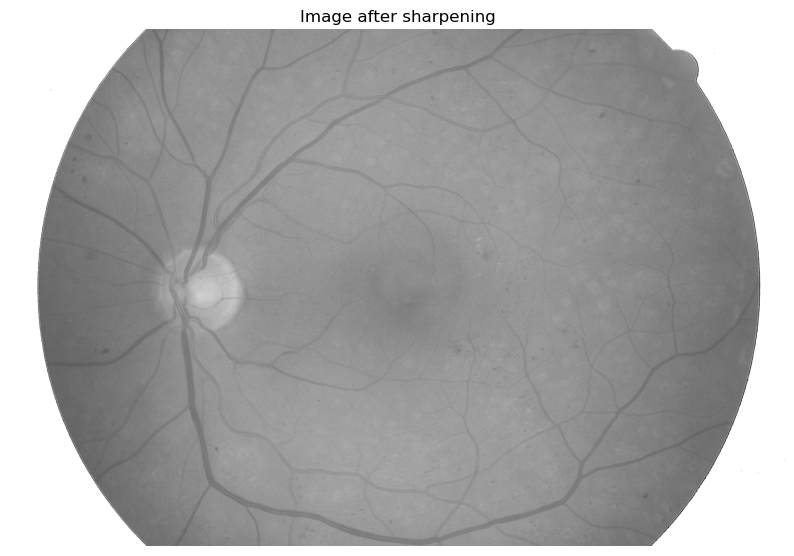

In [46]:
# Wyostrzenie obrazu
sharp_image = cv2.filter2D(gray, -1, np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]))
show_image(sharp_image, title='Image after sharpening')

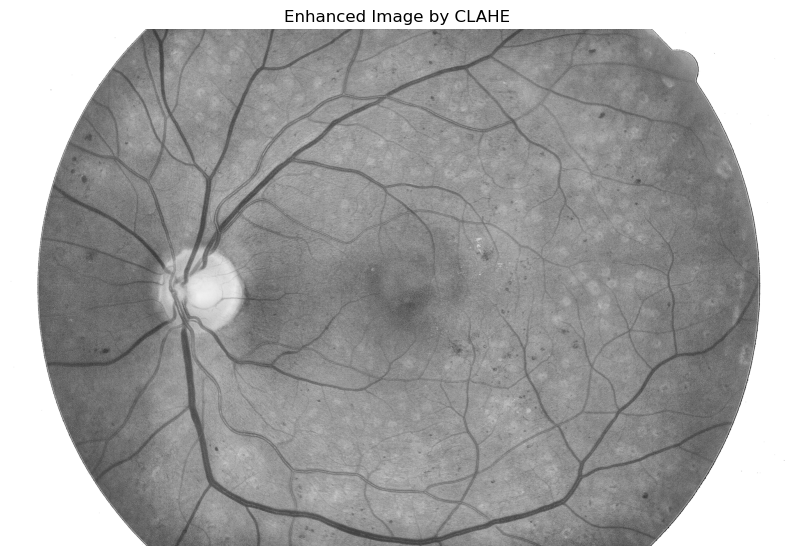

In [47]:
# Zwiększenie kontrastu
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
enhanced_image = clahe.apply(sharp_image)
show_image(enhanced_image, title='Enhanced Image by CLAHE') # Contrast Limited Adaptive Histogram Equalization

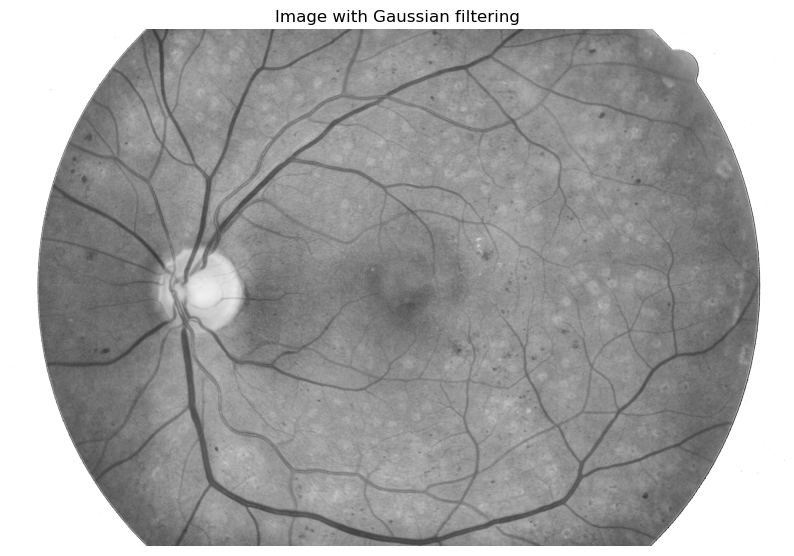

In [48]:
# Filtr bilateralny
bilateralFiltered = cv2.bilateralFilter(enhanced_image,9,50,50)
show_image(bilateralFiltered, title='Image with Gaussian filtering')

In [ ]:
threshold_value = 115 # Ustalenie progu

_, segmented_image = cv2.threshold(bilateralFiltered, threshold_value, 255, cv2.THRESH_BINARY) # segmentacja poprzez progowanie

show_image(segmented_image, title='Segmented Image')

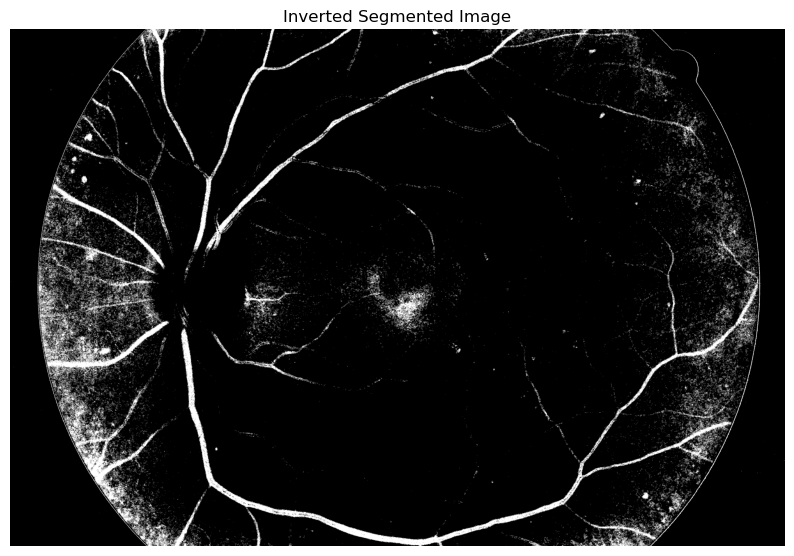

In [58]:
# Odwrócenie kolorów
inverted_segmented_image = 255 - segmented_image
show_image(inverted_segmented_image, title='Inverted Segmented Image')

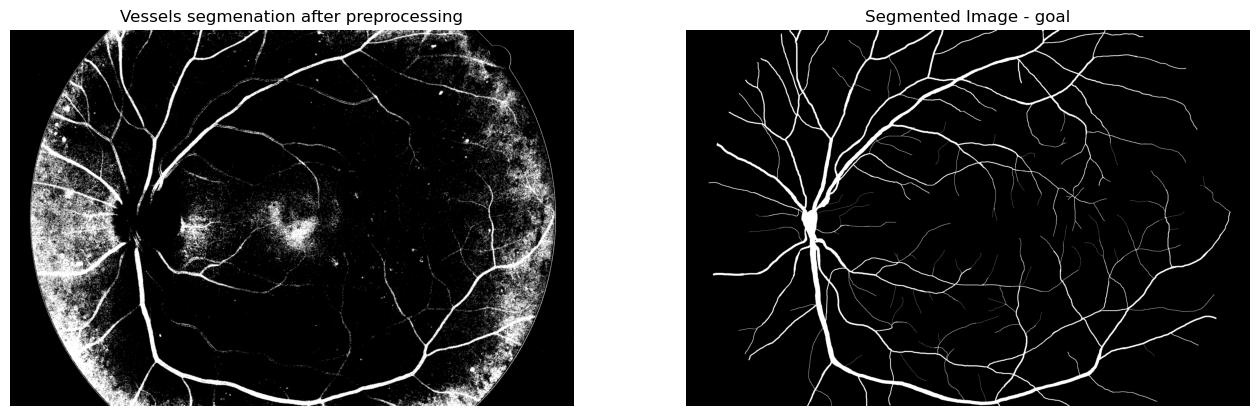

In [51]:
tif_image_path = "HRF-database/manual1/01_dr.tif"
tif_image = Image.open(tif_image_path)

# Konwersja obrazu PIL do numpy array
tif_array = np.array(tif_image)

plt.figure(figsize=(16, 12))

plt.subplot(1, 2, 1)
plt.imshow(inverted_segmented_image, cmap='gray')
plt.title('Vessels segmenation after preprocessing')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(tif_array, cmap='gray')
plt.title('Segmented Image - goal')
plt.axis('off')

plt.show()

### 2. Ekstrakcja cech + klasyfikator do porównań z CNN (SVM / kNN / RF)

In [1]:
import cv2
import numpy as np
import os
from tqdm import tqdm
from skimage.feature import greycomatrix, greycoprops
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

- Funkcja do ekstrakcji cech dla piksela i jego otoczenia

In [ ]:
def extract_features(image, i, j):
    # Pixel
    pixel_value = image[i, j]

    # patch 4x4 
    patch = image[i-1:i+3, j-1:j+3]

    # featues: jasność, średnia z otoczenia, odchylenie standardowe, kontrast
    features = [pixel_value]
    features.append(np.mean(patch))
    features.append(np.std(patch))
    glcm = greycomatrix(patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = greycoprops(glcm, 'contrast')[0, 0]
    features.append(contrast)

    return features

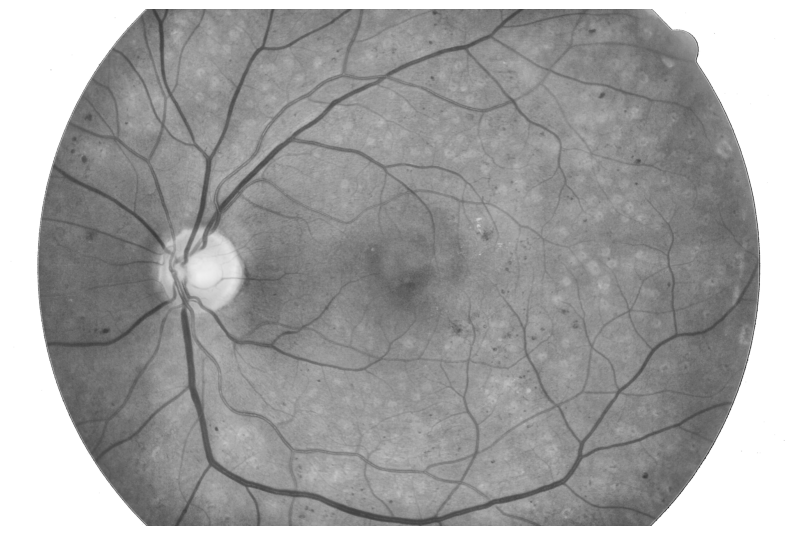

In [60]:
image_for_KNN = bilateralFiltered.copy()
show_image(image_for_KNN)

In [ ]:
images_path = 'HRF-database/images/'
segmented_images_path = 'HRF-database/manual1/'

original_images = []
segmentation_images = []

for filename in os.listdir(images_path):
    if filename.endswith('.JPG') or filename.endswith('.tif'):
        # original image
        original_image = cv2.imread(os.path.join(images_path, filename))
        original_images.append(original_image)

        # segmented image
        segmentation_image = cv2.imread(os.path.join(segmented_images_path, filename), cv2.IMREAD_GRAYSCALE)
        segmentation_images.append(segmentation_image)

features_list = []
labels_list = []

for original_image, segmentation_image in tqdm(zip(original_images, segmentation_images), total=len(original_images)):
    # iterating trough pixels
    for i in range(1, original_image.shape[0]-1):
        for j in range(1, original_image.shape[1]-1):
            # feature extraction
            features = extract_features(original_image, i, j)

            # label
            label = segmentation_image[i, j] // 255  # 0: black, 1: white

            features_list.append(features)
            labels_list.append(label)

# Normalizing features 
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(features_list)

# Dataset
X = np.array(X_normalized)
y = np.array(labels_list)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

classifier.fit(X_train, y_train)

# Raport klasyfikacji
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

### 3. Model głębokiej konwolucyjnej sieci neuronowej

### 4. Wyniki dla przykładowych instancji